In [ ]:
# solo si lo pide instalar primero:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter

In [ ]:
# -- Configuración de visualización --
pd.set_option("display.max_columns", None)

# -- 1. Carga de datos --
# Cargar los archivos CSV solicitando la subida desde el PC local.
from google.colab import files
import io

print("Por favor, sube el archivo CSV de entrenamiento (ej. df_train.csv):")
uploaded_train = files.upload()

# Asumiendo que solo se sube un archivo por solicitud
for fn_train in uploaded_train.keys():
  print(f'Subido "{fn_train}" con longitud {len(uploaded_train[fn_train])} bytes')
  df_train = pd.read_csv(io.StringIO(uploaded_train[fn_train].decode('utf-8')))

print("\nPor favor, sube el archivo CSV de prueba (ej. df_test.csv):")
uploaded_test = files.upload()

# Asumiendo que solo se sube un archivo por solicitud
for fn_test in uploaded_test.keys():
  print(f'Subido "{fn_test}" con longitud {len(uploaded_test[fn_test])} bytes')
  df_test = pd.read_csv(io.StringIO(uploaded_test[fn_test].decode('utf-8')))

print("\nDatos de entrenamiento y prueba cargados exitosamente.")

Por favor, sube el archivo CSV de entrenamiento (ej. df_train.csv):


Saving customer_churn_dataset-training-master.csv to customer_churn_dataset-training-master.csv
Subido "customer_churn_dataset-training-master.csv" con longitud 23448754 bytes

Por favor, sube el archivo CSV de prueba (ej. df_test.csv):


Saving customer_churn_dataset-testing-master.csv to customer_churn_dataset-testing-master.csv
Subido "customer_churn_dataset-testing-master.csv" con longitud 3282220 bytes

Datos de entrenamiento y prueba cargados exitosamente.


In [ ]:
# Combinar los datasets para un preprocesamiento uniforme
df = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
display(df.head(10))

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
5,8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0
6,9.0,58.0,Female,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0
7,10.0,55.0,Female,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0
8,11.0,39.0,Male,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0
9,12.0,64.0,Female,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0


In [ ]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505207 entries, 0 to 505206
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         505206 non-null  float64
 1   Age                505206 non-null  float64
 2   Gender             505206 non-null  object 
 3   Tenure             505206 non-null  float64
 4   Usage Frequency    505206 non-null  float64
 5   Support Calls      505206 non-null  float64
 6   Payment Delay      505206 non-null  float64
 7   Subscription Type  505206 non-null  object 
 8   Contract Length    505206 non-null  object 
 9   Total Spend        505206 non-null  float64
 10  Last Interaction   505206 non-null  float64
 11  Churn              505206 non-null  float64
dtypes: float64(9), object(3)
memory usage: 46.3+ MB


None

In [ ]:
# -- 2. Limpieza de datos --
# Eliminar la columna CustomerID ya que no es útil para el modelo
df.drop("CustomerID", axis=1, inplace=True)
# Guardar el número de filas antes de eliminar nulos para el mensaje informativo
initial_rows = df.shape[0]

# Eliminar filas con valores nulos
df.dropna(inplace=True)

# Imprimir cuántas filas fueron eliminadas
rows_after_dropna = df.shape[0]
rows_dropped = initial_rows - rows_after_dropna
print(f"\nSe eliminaron {rows_dropped} filas con valores nulos.")


# Verificar valores nulos después de eliminar filas
print("\nValores nulos por columna después de eliminar filas con nulos:")
print(df.isnull().sum())

# Verificar valores duplicados
print(f"\nNúmero de filas duplicadas: {df.duplicated().sum()}")
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print("Se eliminaron las filas duplicadas.")

# Reemplazar valores de texto inconsistentes en la columna 'Gender'
# Se corrige la forma de usar replace para evitar el FutureWarning
df['Gender'] = df['Gender'].replace({'Male': 'Male', 'Female': 'Female'})
print("\nValores únicos en la columna 'Gender' después de la limpieza:")
print(df['Gender'].unique())

# Redefinir X y y después de la limpieza para asegurar que no contienen nulos
X = df.drop("Churn", axis=1)
y = df["Churn"]


Se eliminaron 1 filas con valores nulos.

Valores nulos por columna después de eliminar filas con nulos:
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

Número de filas duplicadas: 0

Valores únicos en la columna 'Gender' después de la limpieza:
['Female' 'Male']


In [ ]:
# -- 3. Preprocesamiento de datos --
# Separar las variables predictoras (X) de la variable objetivo (y)
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Identificar variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(exclude=['object']).columns

# Crear un preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [ ]:
# -- 4. Balanceo de clases --
print("\nDistribución original de la variable 'Churn':")
churn_counts = y.value_counts()
print(churn_counts)

# Identificar la clase minoritaria y calcular su porcentaje
minority_class = churn_counts.idxmin()
minority_count = churn_counts.min()
total_count = len(y)
minority_percentage = (minority_count / total_count) * 100

print(f"Clase minoritaria: {minority_class}")
print(f"Porcentaje de la clase minoritaria: {minority_percentage:.2f}%")



Distribución original de la variable 'Churn':
Churn
1.0    280492
0.0    224714
Name: count, dtype: int64
Clase minoritaria: 0.0
Porcentaje de la clase minoritaria: 44.48%


### Dado que el dataset está desequilibrado, usaremos SMOTE para el oversampling.
### SMOTE se aplicará solo al conjunto de entrenamiento dentro del pipeline.
### Esto previene el data leakage.

In [ ]:
# -- 5. Selección de características --
# Usaremos la importancia de las características de un RandomForest
# para seleccionar las más relevantes.
print("\nSeleccionando características más relevantes...")

# Asegurarse de que CustomerID sea excluido si aún está presente
if 'CustomerID' in X.columns:
    X_selector = X.drop('CustomerID', axis=1)
else:
    X_selector = X.copy() # Usar una copia si CustomerID ya fue eliminado

# Identificar variables categóricas y numéricas en el DataFrame sin CustomerID
categorical_features_selector = X_selector.select_dtypes(include=['object']).columns
numerical_features_selector = X_selector.select_dtypes(exclude=['object']).columns

# Crear un preprocesador para las columnas SIN CustomerID
preprocessor_selector = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_selector),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_selector)
    ])


pipeline_selector = Pipeline(steps=[
    ('preprocessor', preprocessor_selector),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Entrenar el pipeline en el conjunto completo de datos SIN CustomerID
pipeline_selector.fit(X_selector, y)
importances = pipeline_selector.named_steps['classifier'].feature_importances_

# Obtener los nombres de las características después del preprocesamiento
ohe_feature_names = pipeline_selector.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features_selector)
all_feature_names = np.concatenate([numerical_features_selector, ohe_feature_names])

# Crear un DataFrame con la importancia de las características
feature_importances_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances}).sort_values('importance', ascending=False)
print(feature_importances_df)

# Seleccionar las características con una importancia mayor a la media
mean_importance = feature_importances_df['importance'].mean()
selected_features_names = feature_importances_df[feature_importances_df['importance'] > mean_importance]['feature'].tolist()
print(f"\nCaracterísticas seleccionadas (importancia > {mean_importance:.4f}):")
print(selected_features_names)

# Reajustar el preprocesador para usar solo las características seleccionadas
# NOTA: Este preprocesador NO se usa en esta celda, sino en las celdas subsiguientes
# para transformar X_train y X_test. Lo redefinimos aquí para claridad.
# Las características seleccionadas (selected_features_names) ahora son las que se usarán.
# La división de datos y la aplicación final del preprocesador se hará en la siguiente celda.


Seleccionando características más relevantes...
                       feature  importance
3                Support Calls    0.251390
5                  Total Spend    0.192319
4                Payment Delay    0.140957
0                          Age    0.128879
13     Contract Length_Monthly    0.072679
6             Last Interaction    0.067891
1                       Tenure    0.043014
2              Usage Frequency    0.033152
12      Contract Length_Annual    0.020085
14   Contract Length_Quarterly    0.014482
8                  Gender_Male    0.013601
7                Gender_Female    0.012437
9      Subscription Type_Basic    0.003342
11  Subscription Type_Standard    0.002905
10   Subscription Type_Premium    0.002867

Características seleccionadas (importancia > 0.0667):
['Support Calls', 'Total Spend', 'Payment Delay', 'Age', 'Contract Length_Monthly', 'Last Interaction']


In [ ]:
# Seleccionar las características con una importancia mayor a la media
mean_importance = feature_importances_df['importance'].mean()
selected_features_names = feature_importances_df[feature_importances_df['importance'] > mean_importance]['feature'].tolist()
print(f"\nCaracterísticas seleccionadas (importancia > {mean_importance:.4f}):")
print(selected_features_names)

# Aplicar el preprocesador a los datos completos antes de la división
X_processed = preprocessor.fit_transform(X)

# Obtener los nombres de las características después del preprocesamiento completo
# Esto es necesario para poder seleccionar las columnas correctas de X_processed
ohe_feature_names_processed = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names_processed = np.concatenate([numerical_features, ohe_feature_names_processed])

# Crear un DataFrame (o similar) de los datos preprocesados para poder seleccionar por nombre de columna
# Esto puede ser ineficiente para datasets muy grandes, otra opción es manejar los índices directamente
X_processed_df = pd.DataFrame(X_processed, columns=all_feature_names_processed)

# Seleccionar solo las características importantes de los datos preprocesados
X_selected_processed = X_processed_df[selected_features_names]

# Dividir los datos preprocesados y seleccionados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_selected_processed, y, test_size=0.2, random_state=42, stratify=y)

print("\nDimensiones de los conjuntos de entrenamiento y prueba después de la selección de características:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Características seleccionadas (importancia > 0.0667):
['Support Calls', 'Total Spend', 'Payment Delay', 'Age', 'Contract Length_Monthly', 'Last Interaction']

Dimensiones de los conjuntos de entrenamiento y prueba después de la selección de características:
X_train: (404164, 6)
X_test: (101042, 6)
y_train: (404164,)
y_test: (101042,)


In [ ]:
# -- 6. Modelado y ajuste de hiperparámetros --
# Definir los modelos y sus hiperparámetros

# Since X_train and X_test already contain the preprocessed and selected features,
# we don't need a ColumnTransformer inside the pipelines.

pipelines = {
    'Logistic Regression': ImbPipeline(steps=[
        ('sampler', SMOTE(random_state=42)),
        ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
    ]),
    'Decision Tree': ImbPipeline(steps=[
        ('sampler', SMOTE(random_state=42)),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'Random Forest': ImbPipeline(steps=[
        ('sampler', SMOTE(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))
    ])
}

# Definir los grids de hiperparámetros para Grid Search
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 1, 10]
    },
    'Decision Tree': {
        'classifier__max_depth': [3, 5, 10, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_features': ['sqrt', 'log2']
    }
}

# Almacenar los resultados de la búsqueda
results = []
best_models = {}

print("\nRealizando Grid Search para cada modelo...")
for model_name, pipeline in pipelines.items():
    print(f"Optimizando {model_name}...")
    # Use X_train and y_train which already contain only the selected features
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_models[model_name] = grid_search.best_estimator_

    results.append({
        'Model': model_name,
        'Best Params': grid_search.best_params_,
        'Best F1-Score (CV)': grid_search.best_score_
    })
    print(f"Grid Search para {model_name} completado. Mejores parámetros: {grid_search.best_params_}")


Realizando Grid Search para cada modelo...
Optimizando Logistic Regression...
Grid Search para Logistic Regression completado. Mejores parámetros: {'classifier__C': 10}
Optimizando Decision Tree...
Grid Search para Decision Tree completado. Mejores parámetros: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2}
Optimizando Random Forest...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Grid Search para Random Forest completado. Mejores parámetros: {'classifier__max_features': 'sqrt', 'classifier__n_estimators': 200}



Evaluando los modelos optimizados en el conjunto de prueba...

Resumen de Métricas de Evaluación en Datos de Prueba:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
1        Decision Tree    0.9282     0.8991  0.9807    0.9381  0.9450
2        Random Forest    0.9268     0.8987  0.9784    0.9369  0.9412
0  Logistic Regression    0.8384     0.8846  0.8153    0.8485  0.9053


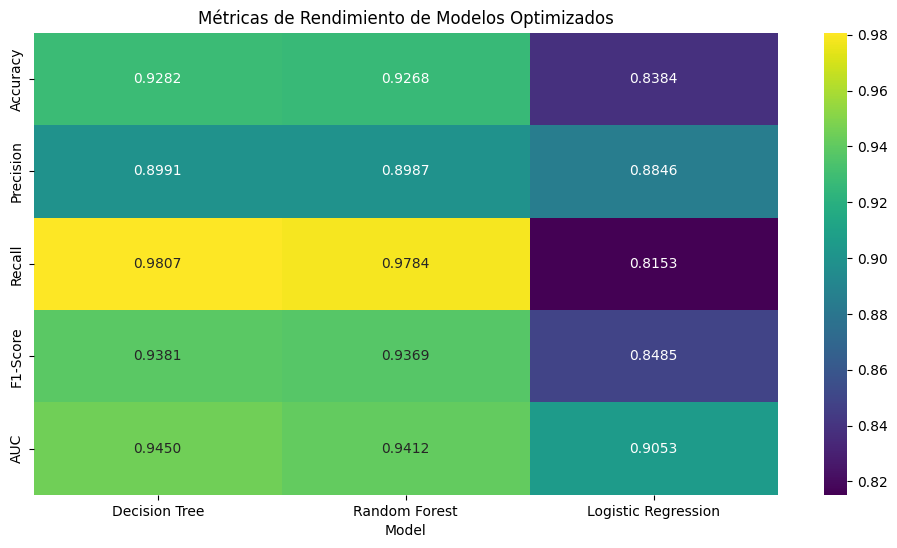

In [ ]:
# -- 7. Evaluación de modelos optimizados --
print("\nEvaluando los modelos optimizados en el conjunto de prueba...")
eval_metrics = []
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    eval_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc_score
    })

results_df = pd.DataFrame(eval_metrics).sort_values(by='F1-Score', ascending=False)
print("\nResumen de Métricas de Evaluación en Datos de Prueba:")
print(results_df.round(4))

# Visualizar las métricas
plt.figure(figsize=(12, 6))
sns.heatmap(results_df.set_index('Model').T, annot=True, cmap='viridis', fmt=".4f")
plt.title('Métricas de Rendimiento de Modelos Optimizados')
plt.show()

In [ ]:
# -- 8. Interpretación de resultados --

# 8.1. Análisis de Odds Ratio (Regresión Logística)
print("\n--- Interpretación de la Regresión Logística con Odds Ratio ---")
best_lr_model = best_models['Logistic Regression']
# Acceder al clasificador final dentro del pipeline
lr_classifier = best_lr_model.named_steps['classifier']

# The feature names are the columns of X_test, as X_test is already preprocessed and selected
feature_names = X_test.columns

# Crear un DataFrame con los coeficientes
lr_coefs = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_classifier.coef_[0],
    'Odds Ratio': np.exp(lr_classifier.coef_[0])
}).sort_values(by='Odds Ratio', ascending=False)

print("\nCoeficientes y Odds Ratio de la Regresión Logística:")
display(lr_coefs) # Use display for better formatting

# 8.2. Probabilidad de Churn para las primeras 5 observaciones del conjunto de prueba (Random Forest)
print("\n--- Probabilidad de Churn para las primeras 5 observaciones (Random Forest) ---")
best_rf_model = best_models['Random Forest']
# Acceder al clasificador final dentro del pipeline
rf_classifier = best_rf_model.named_steps['classifier']

# Obtener las probabilidades de abandono (clase 1) para las primeras 5 observaciones de X_test
first_5_obs_X_test = X_test.head(5)
churn_probabilities = best_rf_model.predict_proba(first_5_obs_X_test)[:, 1]

# Get the actual churn values for the first 5 observations using iloc to access by position
# Since X_test and y_test were split together and maintain relative order,
# the first 5 rows of X_test correspond to the first 5 values of y_test.
actual_churn_first_5 = y_test.iloc[:5].values


# Crear un DataFrame para mostrar los resultados
probability_df = pd.DataFrame({
    'Observation Index': first_5_obs_X_test.index, # Keep original index for reference
    'Predicted Churn Probability': churn_probabilities,
    'Actual Churn': actual_churn_first_5
})

print("\nProbabilidad de Churn para las primeras 5 observaciones:")
display(probability_df) # Use display for better formatting


--- Interpretación de la Regresión Logística con Odds Ratio ---

Coeficientes y Odds Ratio de la Regresión Logística:


,Feature,Coefficient,Odds Ratio
4,Contract Length_Monthly,2.055394,7.809916
0,Support Calls,1.253033,3.500944
2,Payment Delay,0.716933,2.048142
3,Age,0.286442,1.331681
5,Last Interaction,0.213119,1.237531
1,Total Spend,-0.764813,0.465421



--- Probabilidad de Churn para las primeras 5 observaciones (Random Forest) ---

Probabilidad de Churn para las primeras 5 observaciones:


,Observation Index,Predicted Churn Probability,Actual Churn
0,173749,0.850,1.0
1,473412,0.875,0.0
2,345622,0.030,0.0
3,189094,0.965,1.0
4,35854,0.655,1.0


##9. Síntesis de Hallazgos y Visualizaciones Adicionales
Tras evaluar el desempeño de nuestros modelos con los datos de prueba, hemos llegado a varias conclusiones importantes que nos gustaría destacar.

Nuestro análisis revela que el modelo de Árbol de Decisión (Decision Tree) fue el que presentó el mejor rendimiento general, obteniendo el F1-Score más alto. Esta métrica es especialmente relevante para nosotros, ya que considera un balance entre la precisión y la exhaustividad (recall), algo fundamental en problemas con clases desbalanceadas como el nuestro. El modelo de Bosque Aleatorio (Random Forest) le siguió muy de cerca, mostrando también un desempeño muy competitivo.

Más allá de la simple predicción, el análisis de la Regresión Logística nos ha permitido interpretar qué factores influyen más en la probabilidad de que un cliente abandone el servicio. Hemos observado, por ejemplo, que tener un contrato mensual o un mayor número de llamadas a soporte incrementa de manera significativa el riesgo de cancelación. Por el contrario, un mayor gasto total parece estar asociado a una menor probabilidad de abandono, lo que sugiere una mayor lealtad en clientes de alto valor.

Adicionalmente, la capacidad del modelo de Bosque Aleatorio para estimar la probabilidad de cancelación para cada cliente nos ofrece una visión más granular, permitiéndonos identificar con mayor confianza el nivel de riesgo individual de cada usuario.

Visualizaciones Sugeridas para un Análisis más Profundo
Con el fin de enriquecer este resumen y comprender mejor el comportamiento de cada modelo, sugerimos la elaboración de las siguientes visualizaciones:

Matrices de Confusión: Estas nos permitirían visualizar de forma clara los aciertos y errores específicos de cada modelo. Es una herramienta clave para entender no solo cuántos errores se cometen, sino qué tipo de errores son, distinguiendo entre falsos positivos y falsos negativos.

Curvas ROC y el Área bajo la Curva (AUC): Al graficar las curvas ROC de nuestros modelos, podremos comparar visualmente su capacidad para distinguir entre clientes que cancelarán y los que no. El valor AUC nos proporcionará una métrica única y agregada del rendimiento general de cada clasificador, facilitando una comparación final sobre cuál de ellos discrimina mejor entre ambas clases.

### Visualizando Matrices de Confusión

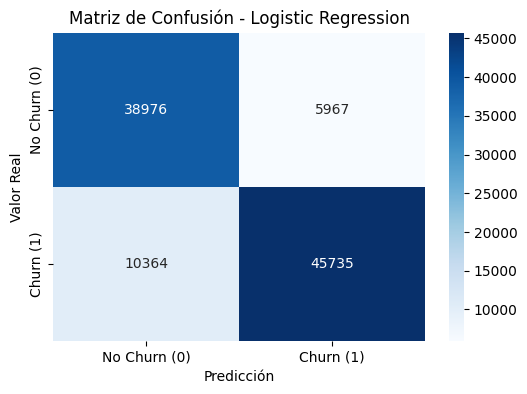

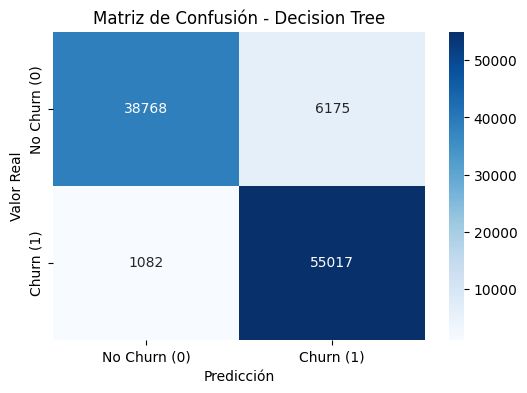

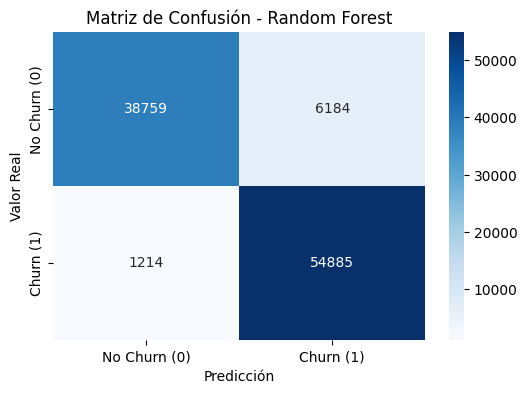

In [ ]:
# Visualizar Matrices de Confusión para los mejores modelos

for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn (0)', 'Churn (1)'], yticklabels=['No Churn (0)', 'Churn (1)'])
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()

### Visualizando Curvas ROC

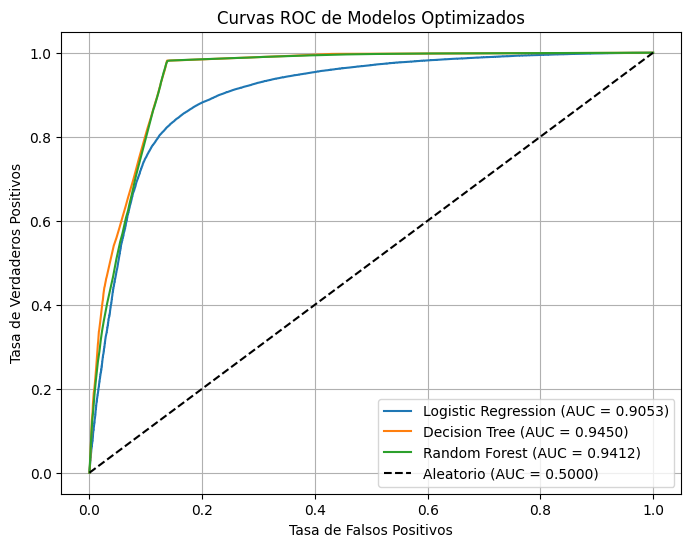

In [ ]:
# Visualizar Curvas ROC

plt.figure(figsize=(8, 6))

for model_name, model in best_models.items():
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    else:
        print(f"El modelo {model_name} no tiene método predict_proba.")

plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio (AUC = 0.5000)') # Curva aleatoria de referencia
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC de Modelos Optimizados')
plt.legend()
plt.grid(True)
plt.show()